## Imports

In [16]:
import pandas as pd
import numpy as np
import nltk
import jieba #for tokenizing Chinese
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import collections
import random
import operator
import io
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


%matplotlib inline
pd.set_option('display.max_columns', 5400)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 3000)
plt.rcParams['font.family'] = ['SimHei']

## Reading in the Dataframe

In [17]:
#reference here: https://www.kaggle.com/noxmoon/chinese-official-daily-news-since-2016/downloads/chinese-official-daily-news-since-2016.zip/1


df = pd.read_csv('chinese_news.csv')
print(df.shape)
print(df.columns)
#详细全文” some relatively long news, "国内“ short domestic news, "国际“ short international news.
print(df.head())

(20738, 4)
Index(['date', 'tag', 'headline', 'content'], dtype='object')
         date   tag                                                headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队授予军旗并致训词   
1  2016-01-01  详细全文                                  中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                                《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                      以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                      【年终特稿】关键之年 改革挺进深水区   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [18]:
df['date'].describe()

count          20738
unique          1008
top       2018-09-05
freq              42
Name: date, dtype: object

In [19]:
df['tag'].value_counts()

详细全文    11534
国内       6186
国际       3018
Name: tag, dtype: int64

## Tokenizing Data with Jieba

In [20]:
%%time
#we only need the date and content for this particular analysis
subset = pd.DataFrame(df[['date', 'headline', 'content']].astype('str'))

def process_words(x):
    
        stop_words = [line.strip() for line in io.open('中文停用词表.txt', 'r', encoding='utf-8').readlines()]
        filtered = []
        
        seg = jieba.cut(x, cut_all=False) 
        
        for w in seg: 
            if w not in stop_words: 
                filtered.append(w) 
        
        #return ' '.join(seg)
        return filtered


subset['tokenized'] = subset['content'].apply(process_words)

subset.head()


Wall time: 1min 6s


,date,headline,content,tokenized
0,2016-01-01,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队授予军旗并致训词,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015年12月31日在八一大楼隆重举行。中共中央总书记、国家主席、中央军委主席习近平向陆军、火箭军、战略支援部队授予军旗并致训词，代表党中央和中央军委向同志们、向全军部队致以热烈祝贺，强调要坚持以党在新形势下的强军目标为引领，深入贯彻新形势下军事战略方针，全面实施改革强军战略，坚定不移走中国特色强军之路，时刻听从党和人民召唤，忠实履行党和人民赋予的神圣使命，为实现中国梦强军梦作出新的更大的贡献。\n下午4时，成立大会开始，全场高唱国歌。仪仗礼兵护卫着鲜艳军旗，正步行进到主席台前。习近平将军旗郑重授予陆军司令员李作成、政治委员刘雷，火箭军司令员魏凤和政治委员王家胜，战略支援部队司令员高津、政治委员刘福连。陆军、火箭军、战略支援部队主要领导，军容严整、精神抖擞，向习近平敬礼，从习近平手中接过军旗。全场官兵向军旗敬礼。\n授旗仪式后，习近平致训词。他指出：“成立陆军领导机构、火箭军、战略支援部队，是党中央和中央军委着眼实现中国梦强军梦作出的重大决策，是构建中国特色现代军事力量体系的战略举措，必将成为...,"[中国人民解放军, 陆军, 领导, 机构, 中国人民解放军, 火箭, 军, 中国人民解放军, 战略, 支援, 部队, 成立, 大会, 2015, 年, 12, 月, 31, 日, 八一, 大楼, 隆重举行, 中共中央, 总书记, 国家, 主席, 中央军委, 主席, 习近平, 陆军, 火箭, 军, 战略, 支援, 部队, 授予, 军旗, 并致, 训词, 代表, 党中央, 中央军委, 同志, 全军, 部队, 致以, 热烈祝贺, 强调, 坚持, 以党, 新形势下, 强军, 目标, 引领, 深入, 贯彻, 新形势下, 军事, 战略方针, 全面实施, 改革, 强军, 战略, 坚定不移, 走, 中国, 特色, 强军, 路, 时刻, 听从, 党和人民, 召唤, 忠实, 履行, 党和人民, 赋予, 神圣, 使命, 实现, 中国, 梦, 强军, 梦, 作出, 新, 更, 贡献, \n, 下午, 时, 成立, 大会, 全场, 高, 唱国歌, 仪仗, 礼兵, 护卫, 鲜艳, ...]"
1,2016-01-01,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强调，党的十八大以来，党中央、中央军委和习主席围绕实现强军目标，统筹军队革命化、现代化、正规化建设，统筹军事力量建设和运用，统筹经济建设和国防建设，制定新形势下军事战略方针，提出一系列重大方针原则，作出一系列重大决策部署。贯彻落实党中央、中央军委和习主席的重大战略谋划和战略设计，必须深化国防和军队改革，全面实施改革强军战略，坚定不移走中国特色强军之路。\n《意见》指出，深化国防和军队改革的指导思想是，深入贯彻党的十八大和十八届三中、四中、五中全会精神，以马克思列宁主义、毛泽东思想、邓小平理论、“三个代表”重要思想、科学发展观为指导，深入贯彻习主席系列重要讲话精神特别是国防和军队建设重要论述，按照“四个全面”战略布局要求，以党在新形势下的强军目标为引领，贯彻新形势下军事战略方针，全面实施改革强军战略，着力解决制约国防和军队发展的体制性障碍、结构性矛盾、政策性问题，推进军队组织形态现代化，进一步解放和发展战斗力，进一步解放和增强军队活力，建设同我国国际地位相称、同国家安全和发展利益相适应的巩固...,"[中央军委, 主席, 习近平, 批准, 中央军委, 近日, 印发, 深化, 国防, 军队, 改革, 意见, \n, 意见, 强调, 党, 十八, 党中央, 中央军委, 和习, 主席, 围绕, 实现, 强军, 目标, 统筹, 军队, 革命化, 现代化, 正规化, 建设, 统筹, 军事力量, 建设, 运用, 统筹, 经济, 建设, 国防建设, 制定, 新形势下, 军事, 战略方针, 提出, 一系列, 重大, 方针, 原则, 作出, 一系列, 重大, 决策, 部署, 贯彻落实, 党中央, 中央军委, 和习, 主席, 重大, 战略, 谋划, 战略, 设计, 必须, 深化, 国防, 军队, 改革, 全面实施, 改革, 强军, 战略, 坚定不移, 走, 中国, 特色, 强军, 路, \n, 意见, 指出, 深化, 国防, 军队, 改革, 指导思想, 深入, 贯彻, 党, 十八, 十八, 届, 三中, 四中, 五中全会, 精神, 马克思列宁主义, 毛泽东思想, 邓小平理论, 三个代表, ...]"
2,2016-01-01,《习近平关于严明党的纪律和规矩论述摘编》出版发行,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一书，近日由中央文献出版社、中国方正出版社出版，在全国发行。\n党的十八大以来，中共中央总书记、国家主席、中央军委主席习近平高度重视全面从严治党，站在党和国家全局的高度，围绕严明党的纪律和规矩，发表了一系列重要论述，为加强党的建设，深入推进党风廉政建设和反腐败斗争提供了思想指导和行动指南。认真学习贯彻这些重要论述，对于全党深刻认识坚持党的领导、加强党的建设的极端重要性，准确把握纪律建设的基本要求，贯彻执行新修订的廉洁自律准则和党纪处分条例，坚定不移推进全面从严治党，具有十分重要的意义。\n《论述摘编》共分7个专题：加强纪律建设是全面从严治党的治本之策；严明党的纪律，首要的就是严明政治纪律；严明党的组织纪律，增强组织纪律性；创新党内法规制度，把各项纪律和规矩立起来；使纪律真正成为带电的高压线;抓住领导干部这个“关键少数”；落实管党治党责任，强化监督执纪问责。书中收入200段论述，摘自习近平同志2012年11月16日至2015年10月29日期间的讲话、文章等40多篇重要文献。其中许多论述是第一...,"[中共中央纪律检查委员会, 中共中央文献研究室, 编辑, 习近平, 严明, 党的纪律, 规矩, 论述, 摘编, 一书, 近日, 中央文献出版社, 中国, 方正, 出版社, 出版, 全国, 发行, \n, 党, 十八, 中共中央, 总书记, 国家, 主席, 中央军委, 主席, 习近平, 高度重视, 全面, 从严治党, 站, 党和国家, 全局, 高度, 围绕, 严明, 党的纪律, 规矩, 发表, 一系列, 重要, 论述, 加强, 党的建设, 深入, 推进, 党风廉政, 建设, 反腐败, 斗争, 提供, 思想, 指导, 行动指南, 认真学习, 贯彻, 重要, 论述, 全党, 深刻, 认识, 坚持, 党的领导, 加强, 党的建设, 极端, 重要性, 准确, 把握, 纪律, 建设, 基本, 要求, 贯彻执行, 新, 修订, 廉洁自律, 准则, 党纪处分, 条例, 坚定不移, 推进, 全面, 从严治党, 具有, 十分, 重要, 意义, \n, 论述, 摘编, 共分, 专题, 加强纪律, 建设, 全面, 从严治党, 治本, 之策, ...]"
3,2016-01-01,以实际行动向党中央看齐 向高标准努力,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把践行“三严三实”体现在解决问题的实践当中，以实际行动向党中央看齐、向高标准努力。\n中央政治局专题民主生活会上提出，在践行‘三严三实’上要定位准、标杆高、行之笃，以实际行动不辜负人民重托。\n践行“三严三实”，就要坚定理想信念，永葆全心为民的公仆情怀，保持对党忠诚的政治品格，做政治上的明白人。\n,"[广大党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 中央政治局, 专题, 民主, 生活, 会上, 重要讲话, 纷纷表示, 践行, 三严, 三实, 体现, 解决问题, 实践, 当中, 实际行动, 党中央, 看齐, 高标准, 努力, \n, 中央政治局, 专题, 民主, 生活, 会上, 提出, 践行, ‘, 三严, 三实, ’, 上要, 定位, 准, 标杆, 高, 行之笃, 实际行动, 辜负, 人民, 重托, \n, 践行, 三严, 三实, 坚定, 理想信念, 永葆, 全心, 为民, 公仆, 情怀, 保持, 对党, 忠诚, 政治, 品格, 做, 政治, 明白人, \n]"
4,2016-01-01,【年终特稿】关键之年 改革挺进深水区,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力在妨碍社会公平与正义之处，集中发力在推进国家治理体系和治理能力现代化建设的关键所在。习近平总书记指出：“改革开放只有进行时，没有完成时。”今天的年终特稿，播出第三集《关键之年 改革挺进深水区》。\n这三张曲线图来自刚刚完成的2015中文网络搜索分析报告，由电脑根据“改革”、“深化改革”、“全面深化改革”三个关键词的搜索热度自动生成。从这张图上可以清楚地看到，两年来，对中国“改革”相关话题的搜索量出现了成倍的增长。\n搜索意味着关注，增长的曲线则代表着不断凝聚的改革共识。2015年，习近平总书记主持召开了11次中央全面深化改革领导小组会议，几乎每月一次，86个重要文件在会上通过审议，领导小组确定的101个重点改革任务基本完成，中央各部门完成153个改革任务，各方面共出台改革成果415条，国防和军队改革全面

## Non-NLP Feature Engineering

In [21]:
%%time
def create_xi_count(row):
    xi_names = ['习近平', '习主席', '习书记', '习总书记']
    return 100 *  ((row.count(xi_names[0])/len(row)) + 
                  (row.count(xi_names[1])/len(row)) +
                  (row.count(xi_names[2])/len(row)) +
                  (row.count(xi_names[3])/len(row))) 


def check_xi(row):
    xi_names = ['习近平', '习主席', '习书记', '习总书记']
    if xi_names[0] in row or xi_names[1] in row or xi_names[2] in row or xi_names[3] in row:
        return True
    else:
        return False

subset['xi_count'] = subset['tokenized'].apply(create_xi_count)
subset['About Xi'] = subset['headline'].apply(check_xi)

subset.head()

Wall time: 201 ms


,date,headline,content,tokenized,xi_count,About Xi
0,2016-01-01,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队授予军旗并致训词,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015年12月31日在八一大楼隆重举行。中共中央总书记、国家主席、中央军委主席习近平向陆军、火箭军、战略支援部队授予军旗并致训词，代表党中央和中央军委向同志们、向全军部队致以热烈祝贺，强调要坚持以党在新形势下的强军目标为引领，深入贯彻新形势下军事战略方针，全面实施改革强军战略，坚定不移走中国特色强军之路，时刻听从党和人民召唤，忠实履行党和人民赋予的神圣使命，为实现中国梦强军梦作出新的更大的贡献。\n下午4时，成立大会开始，全场高唱国歌。仪仗礼兵护卫着鲜艳军旗，正步行进到主席台前。习近平将军旗郑重授予陆军司令员李作成、政治委员刘雷，火箭军司令员魏凤和政治委员王家胜，战略支援部队司令员高津、政治委员刘福连。陆军、火箭军、战略支援部队主要领导，军容严整、精神抖擞，向习近平敬礼，从习近平手中接过军旗。全场官兵向军旗敬礼。\n授旗仪式后，习近平致训词。他指出：“成立陆军领导机构、火箭军、战略支援部队，是党中央和中央军委着眼实现中国梦强军梦作出的重大决策，是构建中国特色现代军事力量体系的战略举措，必将成为...,"[中国人民解放军, 陆军, 领导, 机构, 中国人民解放军, 火箭, 军, 中国人民解放军, 战略, 支援, 部队, 成立, 大会, 2015, 年, 12, 月, 31, 日, 八一, 大楼, 隆重举行, 中共中央, 总书记, 国家, 主席, 中央军委, 主席, 习近平, 陆军, 火箭, 军, 战略, 支援, 部队, 授予, 军旗, 并致, 训词, 代表, 党中央, 中央军委, 同志, 全军, 部队, 致以, 热烈祝贺, 强调, 坚持, 以党, 新形势下, 强军, 目标, 引领, 深入, 贯彻, 新形势下, 军事, 战略方针, 全面实施, 改革, 强军, 战略, 坚定不移, 走, 中国, 特色, 强军, 路, 时刻, 听从, 党和人民, 召唤, 忠实, 履行, 党和人民, 赋予, 神圣, 使命, 实现, 中国, 梦, 强军, 梦, 作出, 新, 更, 贡献, \n, 下午, 时, 成立, 大会, 全场, 高, 唱国歌, 仪仗, 礼兵, 护卫, 鲜艳, ...]",2.014652,True
1,2016-01-01,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强调，党的十八大以来，党中央、中央军委和习主席围绕实现强军目标，统筹军队革命化、现代化、正规化建设，统筹军事力量建设和运用，统筹经济建设和国防建设，制定新形势下军事战略方针，提出一系列重大方针原则，作出一系列重大决策部署。贯彻落实党中央、中央军委和习主席的重大战略谋划和战略设计，必须深化国防和军队改革，全面实施改革强军战略，坚定不移走中国特色强军之路。\n《意见》指出，深化国防和军队改革的指导思想是，深入贯彻党的十八大和十八届三中、四中、五中全会精神，以马克思列宁主义、毛泽东思想、邓小平理论、“三个代表”重要思想、科学发展观为指导，深入贯彻习主席系列重要讲话精神特别是国防和军队建设重要论述，按照“四个全面”战略布局要求，以党在新形势下的强军目标为引领，贯彻新形势下军事战略方针，全面实施改革强军战略，着力解决制约国防和军队发展的体制性障碍、结构性矛盾、政策性问题，推进军队组织形态现代化，进一步解放和发展战斗力，进一步解放和增强军队活力，建设同我国国际地位相称、同国家安全和发展利益相适应的巩固...,"[中央军委, 主席, 习近平, 批准, 中央军委, 近日, 印发, 深化, 国防, 军队, 改革, 意见, \n, 意见, 强调, 党, 十八, 党中央, 中央军委, 和习, 主席, 围绕, 实现, 强军, 目标, 统筹, 军队, 革命化, 现代化, 正规化, 建设, 统筹, 军事力量, 建设, 运用, 统筹, 经济, 建设, 国防建设, 制定, 新形势下, 军事, 战略方针, 提出, 一系列, 重大, 方针, 原则, 作出, 一系列, 重大, 决策, 部署, 贯彻落实, 党中央, 中央军委, 和习, 主席, 重大, 战略, 谋划, 战略, 设计, 必须, 深化, 国防, 军队, 改革, 全面实施, 改革, 强军, 战略, 坚定不移, 走, 中国, 特色, 强军, 路, \n, 意见, 指出, 深化, 国防, 军队, 改革, 指导思想, 深入, 贯彻, 党, 十八, 十八, 届, 三中, 四中, 五中全会, 精神, 马克思列宁主义, 毛泽东思想, 邓小平理论, 三个代表, ...]",0.255102,False
2,2016-01-01,《习近平关于严明党的纪律和规矩论述摘编》出版发行,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一书，近日由中央文献出版社、中国方正出版社出版，在全国发行。\n党的十八大以来，中共中央总书记、国家主席、中央军委主席习近平高度重视全面从严治党，站在党和国家全局的高度，围绕严明党的纪律和规矩，发表了一系列重要论述，为加强党的建设，深入推进党风廉政建设和反腐败斗争提供了思想指导和行动指南。认真学习贯彻这些重要论述，对于全党深刻认识坚持党的领导、加强党的建设的极端重要性，准确把握纪律建设的基本要求，贯彻执行新修订的廉洁自律准则和党纪处分条例，坚定不移推进全面从严治党，具有十分重要的意义。\n《论述摘编》共分7个专题：加强纪律建设是全面从严治党的治本之策；严明党的纪律，首要的就是严明政治纪律；严明党的组织纪律，增强组织纪律性；创新党内法规制度，把各项纪律和规矩立起来；使纪律真正成为带电的高压线;抓住领导干部这个“关键少数”；落实管党治党责任，强化监督执纪问责。书中收入200段论述，摘自习近平同志2012年11月16日至2015年10月29日期间的讲话、文章等40多篇重要文献。其中许多论述是第一...,"[中共中央纪律检查委员会, 中共中央文献研究室, 编辑, 习近平, 严明, 党的纪律, 规矩, 论述, 摘编, 一书, 近日, 中央文献出版社, 中国, 方正, 出版社, 出版, 全国, 发行, \n, 党, 十八, 中共中央, 总书记, 国家, 主席, 中央军委, 主席, 习近平, 高度重视, 全面, 从严治党, 站, 党和国家, 全局, 高度, 围绕, 严明, 党的纪律, 规矩, 发表, 一系列, 重要, 论述, 加强, 党的建设, 深入, 推进, 党风廉政, 建设, 反腐败, 斗争, 提供, 思想, 指导, 行动指南, 认真学习, 贯彻, 重要, 论述, 全党, 深刻, 认识, 坚持, 党的领导, 加强, 党的建设, 极端, 重要性, 准确, 把握, 纪律, 建设, 基本, 要求, 贯彻执行, 新, 修订, 廉洁自律, 准则, 党纪处分, 条例, 坚定不移, 推进, 全面, 从严治党, 具有, 十分, 重要, 意义, \n, 论述, 摘编, 共分, 专题, 加强纪律, 建设, 全面, 从严治党, 治本, 之策, ...]",1.746725,True
3,2016-01-01,以实际行动向党中央看齐 向高标准努力,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把践行“三严三实”体现在解决问题的实践当中，以实际行动向党中央看齐、向高标准努力。\n中央政治局专题民主生活会上提出，在践行‘三严三实’上要定位准、标杆高、行之笃，以实际行动不辜负人民重托。\n践行“三严三实”，就要坚定理想信念，永葆全心为民的公仆情怀，保持对党忠诚的政治品格，做政治上的明白人。\n,"[广大党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 中央政治局, 专题, 民主, 生活, 会上, 重要讲话, 纷纷表示, 践行, 三严, 三实, 体现, 解决问题, 实践, 当中, 实际行动, 党中央, 看齐, 高标准, 努力, \n, 中央政治局, 专题, 民主, 生活, 会上, 提出, 践行, ‘, 三严, 三实, ’, 上要, 定位, 准, 标杆, 高, 行之笃, 实际行动, 辜负, 人民, 重托, \n, 践行, 三严, 三实, 坚定, 理想信念, 永葆, 全心, 为民, 公仆, 情怀, 保持, 对党, 忠诚, 政治, 品格, 做, 政治, 明白人, \n]",1.470588,False
4,2016-01-01,【年终特稿】关键之年 改革挺进深水区,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力在妨碍社会公平与正义之处，集中发力在推进国家治理体系和治理能力现代化建设的关键所在。习近平总书记指出：“改革开放只有进行时，没有完成时。”今天的年终特稿，播出第三集《关键之年 改革挺进深水区》。\n这三张曲线图来自刚刚完成的2015中文网络搜索分析报告，由电脑根据“改革”、“深化改革”、“全面深化改革”三个关键词的搜索热度自动生成。从这张图上可以清楚地看到，两年来，对中国“改革”相关话题的搜索量出现了成倍的增长。\n搜索意味着关注，增长的曲线则代表着不断凝聚的改革共识。2015年，习近平总书记主持召开了11次中央全面深化改革领导小组会议，几乎每月一次，8

In [22]:
#changing certain rows if they are actually about Xi Jinping or not
change_list = [28, 47, 108, 141, 205, 264, 305, 1563,
               2525, 2761, 3322, 3791, 4423, 5671, 8331,
               9409, 11062, 12458, 12526, 12902, 13595,
              13903, 15057, 15107, 15792, 16313, 16315,
              16321, 17188, 18149, 18264, 19166, 20524,]
subset['About Xi'].iloc[change_list] = True

In [23]:
xi_subset = subset[subset['About Xi'] == True]
non_xi = subset[subset['About Xi'] == False]

## Visualizing Data with Graphs and Numbers

In [27]:
fig = px.histogram(subset, x="date", y="About Xi", color='About Xi', title='Ratio of Articles About Xi')
fig.show()

In [28]:
print('Jan 2016 to March 2016: ', xi_subset['About Xi'][xi_subset['date'] < '2016-03-01'].value_counts().median() / non_xi['About Xi'][non_xi['date'] < '2016-03-01'].value_counts().median())
print('March 2016 to June 2016: ', xi_subset['About Xi'][(xi_subset['date'] > '2016-03-01') & (xi_subset['date'] < '2016-06-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2016-03-01') & (non_xi['date'] < '2016-06-01')].value_counts().median())
print('June 2016 to Sept 2016: ', xi_subset['About Xi'][(xi_subset['date'] > '2016-06-01') & (xi_subset['date'] < '2016-09-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2016-06-01') & (non_xi['date'] < '2016-09-01')].value_counts().median())
print('Sept 2016 to Jan 2017: ', xi_subset['About Xi'][(xi_subset['date'] > '2016-09-01') & (xi_subset['date'] < '2017-01-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2016-09-01') & (non_xi['date'] < '2017-01-01')].value_counts().median())
print('Jan 2017 to March 2017: ', xi_subset['About Xi'][(xi_subset['date'] > '2017-01-01') & (xi_subset['date'] < '2017-03-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2017-01-01') & (non_xi['date'] < '2017-03-01')].value_counts().median())
print('March 2017 to June 2017: ', xi_subset['About Xi'][(xi_subset['date'] > '2017-03-01') & (xi_subset['date'] < '2017-06-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2017-03-01') & (non_xi['date'] < '2017-06-01')].value_counts().median())
print('June 2017 to Sept 2017: ', xi_subset['About Xi'][(xi_subset['date'] > '2017-06-01') & (xi_subset['date'] < '2017-09-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2017-06-01') & (non_xi['date'] < '2017-09-01')].value_counts().median())
print('Sept 2017 to Jan 2018: ', xi_subset['About Xi'][(xi_subset['date'] > '2017-09-01') & (xi_subset['date'] < '2018-01-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2017-09-01') & (non_xi['date'] < '2018-01-01')].value_counts().median())
print('Jan 2018 to March 2018: ', xi_subset['About Xi'][(xi_subset['date'] > '2018-01-01') & (xi_subset['date'] < '2018-03-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2018-01-01') & (non_xi['date'] < '2018-03-01')].value_counts().median())
print('March 2018 to June 2018: ', xi_subset['About Xi'][(xi_subset['date'] > '2018-03-01') & (xi_subset['date'] < '2018-06-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2018-03-01') & (non_xi['date'] < '2018-06-01')].value_counts().median())
print('June 2018 to Sept 2018: ', xi_subset['About Xi'][(xi_subset['date'] > '2018-06-01') & (xi_subset['date'] < '2018-09-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2018-06-01') & (non_xi['date'] < '2018-09-01')].value_counts().median())
print('Sept 2018 and beyond: ', xi_subset['About Xi'][(xi_subset['date'] > '2018-09-01')].value_counts().median() / non_xi['About Xi'][(non_xi['date'] > '2018-09-01')].value_counts().median())

Jan 2016 to March 2016:  0.10284463894967177
March 2016 to June 2016:  0.09056603773584905
June 2016 to Sept 2016:  0.08029197080291971
Sept 2016 to Jan 2017:  0.12330754352030948
Jan 2017 to March 2017:  0.06571936056838366
March 2017 to June 2017:  0.08848614072494669
June 2017 to Sept 2017:  0.111957796014068
Sept 2017 to Jan 2018:  0.10711331679073614
Jan 2018 to March 2018:  0.09573459715639811
March 2018 to June 2018:  0.16083086053412463
June 2018 to Sept 2018:  0.15458937198067632
Sept 2018 and beyond:  0.20531757754800592


## Begin NLP

In [26]:
#baseline of .89
print(len(non_xi)/len(subset))

0.8978686469283441


In [24]:
labeled_list = []

def label_articles(df, col, label):
    row = 0
    while row < len(df):
        #creates list of tuples with a label of being true or False About Xi
        labeled_list.append((df[col].iloc[row], df[label].iloc[row]))
        row += 1

#creates a list filled with labeled tuples
label_articles(subset, 'content', 'About Xi')

In [29]:
#This returns a bunch of FreqDists (one for each row) in a list
non_xi_freqdist = [nltk.FreqDist(row) for row in non_xi['tokenized']]
xi_freqdist = [nltk.FreqDist(row) for row in xi_subset['tokenized']]
sub_freqdist = [nltk.FreqDist(row) for row in subset['tokenized']]

In [30]:

#this function goes through the list of FreqDists, then adds up all the counts of each token
#it then returns another dictionary with the token and it's total count from all objects in the list
def create_summary(freqlist):
    entry_dict = {}
    i = 0
    while i < len(freqlist):        
        for t in freqlist[i].most_common():
            if t[0] not in entry_dict.keys():
                entry_dict[t[0]] = t[1]
            elif t[0] in entry_dict.keys():
                entry_dict[t[0]] += t[1]
        i += 1
    #sort of cheating to get the linebreak out of this:
    entry_dict['\n'] = 0
    return entry_dict

non_xi_freqdist = create_summary(non_xi_freqdist)
xi_freqdist = create_summary(xi_freqdist)
sub_freqdist = create_summary(sub_freqdist)

In [32]:

sorted_sub_freq = dict(sorted(sub_freqdist.items(), key=operator.itemgetter(1),reverse=True))
#change how many words you want to use as features by seeing how many times they're used throughout the dataset
sorted_sub_freq = {k:v for k, v in sorted_sub_freq.items() if v > 19}

In [33]:
print(len(sorted_sub_freq))

12302
{'发展': 20411, '中国': 18782, '习近平': 13412, '合作': 12334, '新': 11729, '年': 11680, '中': 10948, '国家': 10876, '日': 10744, '工作': 9329, '建设': 8345, '月': 8191, '表示': 7431, '经济': 7335, '主席': 6778, '问题': 6272, '推动': 6271, '全面': 6153, '加强': 6143, '推进': 6055, '今天': 5999, '改革': 5921, '重要': 5598, '会议': 5399, '我国': 5274, '全国': 5243, '创新': 5199, '进行': 5193, '国际': 5048, '实现': 4990, '企业': 4870, '地区': 4817, '说': 4781, '坚持': 4683, '组织': 4589, '人民': 4552, '关系': 4547, '号': 4521, '领域': 4512, '党': 4475, '美国': 4304, '总书记': 4249, '世界': 4233, '总统': 4098, '指出': 4072, '今年': 4019, '政治': 3981, '共同': 3926, '中方': 3919, '政府': 3752, '举行': 3743, '战略': 3680, '更': 3663, '—': 3526, '代表': 3504, '强调': 3495, '目前': 3495, '精神': 3480, '支持': 3475, '社会': 3436, '李克强': 3415, '总理': 3362, '一个': 3327, '中央': 3304, '双方': 3280, '已经': 3267, '安全': 3247, '时代': 3162, '一路': 3138, '深化': 3125, '一带': 3094, '继续': 3091, '促进': 3088, '国务院': 3076, '社会主义': 3071, '叙利亚': 3039, '取得': 2983, '要求': 2980, '国': 2902, '活动': 2896, '增长': 2889, '不断': 2875, '俄罗斯

In [34]:
feature_list = list(sorted_sub_freq.keys())[:5000]

def get_features(labeled_list):
    tokenized = process_words(labeled_list)
    features = {}
    for char_set in feature_list:
        features[char_set] = (char_set in tokenized)
    return features

In [35]:
%%time
#takes roughly 15 minutes when ALL words are used
#4 minutes with only 5k words

#creates a dictionary with all words and whether or not they appear in an article
feature_sets = [(get_features(art), label) for (art, label) in labeled_list]

Wall time: 3min 59s


In [36]:
#print(feature_sets[0])

({'发展': True, '中国': True, '习近平': True, '合作': False, '新': True, '年': True, '中': True, '国家': True, '日': True, '工作': False, '建设': True, '月': True, '表示': True, '经济': False, '主席': True, '问题': False, '推动': False, '全面': False, '加强': True, '推进': True, '今天': False, '改革': True, '重要': True, '会议': False, '我国': True, '全国': False, '创新': False, '进行': False, '国际': False, '实现': True, '企业': False, '地区': False, '说': False, '坚持': True, '组织': False, '人民': False, '关系': False, '号': False, '领域': True, '党': True, '美国': False, '总书记': True, '世界': False, '总统': False, '指出': True, '今年': False, '政治': False, '共同': False, '中方': False, '政府': False, '举行': False, '战略': True, '更': True, '—': False, '代表': True, '强调': True, '目前': False, '精神': False, '支持': False, '社会': False, '李克强': False, '总理': False, '一个': True, '中央': False, '双方': False, '已经': False, '安全': True, '时代': True, '一路': False, '深化': False, '一带': False, '继续': False, '促进': False, '国务院': False, '社会主义': False, '叙利亚': False, '取得': False, '要求': True, '国': False, '活动': 

In [37]:

random.seed(42)
random.shuffle(feature_sets)
print(len(feature_sets))

20738


In [38]:
%%time
train_set = feature_sets[:15000]
test_set = feature_sets[15000:]

Wall time: 0 ns


In [40]:
%%time
classifier = nltk.NaiveBayesClassifier.train(train_set)

Wall time: 1min 11s


In [41]:
#The informative features vary based on the size of the featureset used
print(classifier.show_most_informative_features(n=25))

Most Informative Features
                      薛祥 = True             True : False  =    171.1 : 1.0
                     杨洁篪 = True             True : False  =     75.6 : 1.0
                      我同 = True             True : False  =     67.0 : 1.0
                       丁 = True             True : False  =     57.9 : 1.0
                      分许 = True             True : False  =     57.1 : 1.0
                   中央办公厅 = True             True : False  =     47.4 : 1.0
                     习近平 = False           False : True   =     44.8 : 1.0
                      刘鹤 = True             True : False  =     40.5 : 1.0
                    国事访问 = True             True : False  =     36.3 : 1.0
                      至少 = True            False : True   =     34.7 : 1.0
                     王沪宁 = True             True : False  =     33.0 : 1.0
                  亚太经合组织 = True             True : False  =     32.3 : 1.0
                    团结合作 = True             True : False  =     31.2 : 1.0

## Classifiers and Accuracies

In [42]:
%%time
print(nltk.classify.accuracy(classifier, test_set))

0.85953293830603
Wall time: 1min 20s


In [44]:
%%time
#Check https://www.nltk.org/_modules/nltk/classify/scikitlearn.html for more classifiers
#check out BernoulliNB (specifically for binary classification)



MNB_pipeline = Pipeline([('tfidf', TfidfTransformer()),
                     #getting best 1,000 features
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('nb', MultinomialNB())])

classif = SklearnClassifier(MNB_pipeline)

classif.train(train_set)

Wall time: 49.7 s


<SklearnClassifier(Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('chi2',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x0000027622AD16A8>)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False))>

In [45]:
%%time
print(nltk.classify.accuracy(classif, test_set))

0.9264552108748693
Wall time: 18.6 s


In [46]:
Bern_classif = SklearnClassifier(BernoulliNB(binarize=False))

Bern_classif.train(train_set)

<SklearnClassifier(BernoulliNB(alpha=1.0, binarize=False, class_prior=None, fit_prior=True))>

In [47]:
%%time
print(Bern_classif.labels())
print(nltk.classify.accuracy(Bern_classif, test_set))

[False, True]
0.85953293830603
Wall time: 18.8 s


In [48]:
Log_classif = SklearnClassifier(LogisticRegression(C=1000))

Log_classif.train(train_set)

d:\cs files\lambda\lambda-env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



<SklearnClassifier(LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))>

In [49]:
%%time
print(Log_classif.labels())
print(nltk.classify.accuracy(Log_classif, test_set))

[False, True]
0.9590449634018822
Wall time: 18.4 s


In [50]:

SVC_classif = SklearnClassifier(SVC(), sparse=True)

SVC_classif.train(train_set)

d:\cs files\lambda\lambda-env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



<SklearnClassifier(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))>

In [51]:
%%time
print(SVC_classif.labels())
print(nltk.classify.accuracy(SVC_classif, test_set))

[False, True]
0.9388288602300453
Wall time: 2min 26s


## Comparison of Word Frequencies Between Subsets

In [52]:
###Reserved for graphing the ratio of words in both xi and non_xi categories
xi_count = pd.DataFrame.from_dict(xi_freqdist, orient='index')
non_xi_count = pd.DataFrame.from_dict(non_xi_freqdist, orient='index')
sub_count = pd.DataFrame.from_dict(sub_freqdist, orient='index')

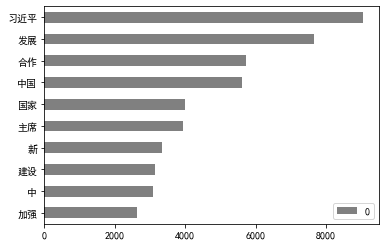

In [53]:
xi_count.sort_values(by=0)[-10:].plot.barh(color='grey');

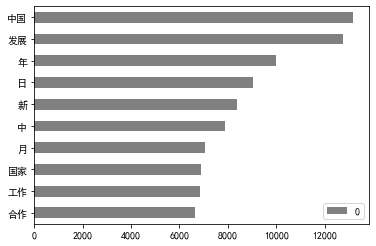

In [54]:
non_xi_count.sort_values(by=0)[-10:].plot.barh(color='grey');

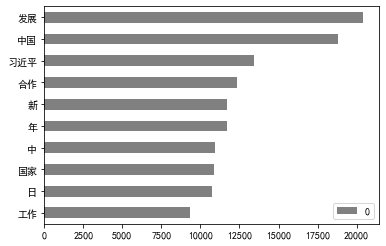

In [55]:
sub_count.sort_values(by=0)[-10:].plot.barh(color='grey');